# Выбор региона для разработки новых нефтяных месторождений.

# План работ:  

- 1 Загрузка и подготовка данных.
- 2 Обучение и проверка модели.
- 3 Подготовка к расчёту прибыли.
- 4 Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели:
- 5 Расчёт прибыли и рисков.
- 6 Общий вывод.

# Описание данных:  

Данные геологоразведки трёх регионов находятся в файлах:
- geo_data_0.csv.
- geo_data_1.csv.
- geo_data_2.csv.  


- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

Стоимость одной тыс. баррелей = 450т.р.

In [1]:
profit_per_1k_barrel = 450000

Бюджет на район 10млрд.р.

In [2]:
district_budget =  10000000000

# 1. Загрузка и подготовка данных

In [3]:
import pandas as pd

from sklearn.preprocessing import OneHotEncoder as ohe

from sklearn.linear_model import LinearRegression as lr

from sklearn.model_selection import train_test_split as tts

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import scipy.stats as st

Загрузим все три выборки:

In [4]:
region_1 = pd.read_csv('datasets/geo_data_0.csv')
region_2 = pd.read_csv('datasets/geo_data_1.csv')
region_3 = pd.read_csv('datasets/geo_data_2.csv')

In [5]:
region_1.head(), region_2.head(), region_3.head()

(      id        f0        f1        f2     product
 0  txEyH  0.705745 -0.497823  1.221170  105.280062
 1  2acmU  1.334711 -0.340164  4.365080   73.037750
 2  409Wp  1.022732  0.151990  1.419926   85.265647
 3  iJLyR -0.032172  0.139033  2.978566  168.620776
 4  Xdl7t  1.988431  0.155413  4.751769  154.036647,
       id         f0         f1        f2     product
 0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
 1  62mP7  14.272088  -3.475083  0.999183   26.953261
 2  vyE1P   6.263187  -5.948386  5.001160  134.766305
 3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
 4  AHL4O  12.702195  -8.147433  5.004363  134.766305,
       id        f0        f1        f2     product
 0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
 1  WJtFt  0.262778  0.269839 -2.530187   56.069697
 2  ovLUW  0.194587  0.289035 -5.586433   62.871910
 3  q6cA6  2.236060 -0.553760  0.930038  114.572842
 4  WPMUX -0.515993  1.716266  5.899011  149.600746)

Проверим наличие дубликатов:

In [6]:
for i in region_1, region_2, region_3:
    print(i.duplicated().sum())

0
0
0


Проверим наличае повторов id:

In [7]:
for i in region_1, region_2, region_3:
    print(len(i['id'].unique()))

99990
99996
99996


In [8]:
for i in region_1, region_2, region_3:
    print(i.shape[0])

100000
100000
100000


Повторы id присутсвуют. Уберём их:

In [9]:
region_1 = region_1.drop_duplicates(subset=['id']).reset_index(drop=True)  # , keep=False)
region_2 = region_2.drop_duplicates(subset=['id']).reset_index(drop=True)  # , keep=False)
region_3 = region_3.drop_duplicates(subset=['id']).reset_index(drop=True)  # , keep=False)

In [10]:
for i in region_1, region_2, region_3:
    print(i.info())
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99990 entries, 0 to 99989
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99990 non-null  object 
 1   f0       99990 non-null  float64
 2   f1       99990 non-null  float64
 3   f2       99990 non-null  float64
 4   product  99990 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99996 entries, 0 to 99995
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99996 entries, 0 to 99995
Data columns (total 5 columns):
 #   Column   Non-Null Count

In [11]:
for i in region_1, region_2, region_3:
    print(len(i['id'].unique()))

99990
99996
99996


Строки с повторяющимися id удалены.  

Посмотрим на графики распределения каждого региона:

                                               region 1


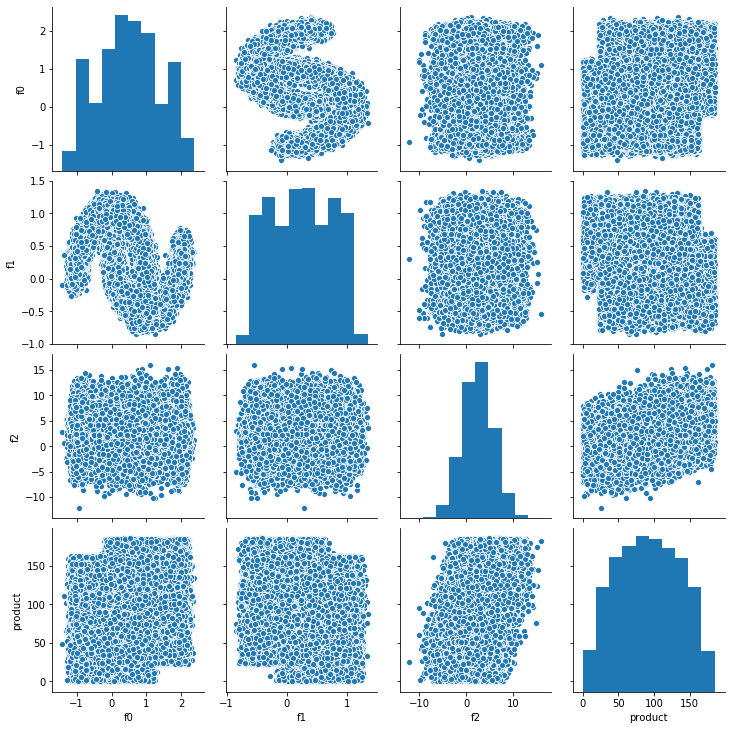


                                               region 2


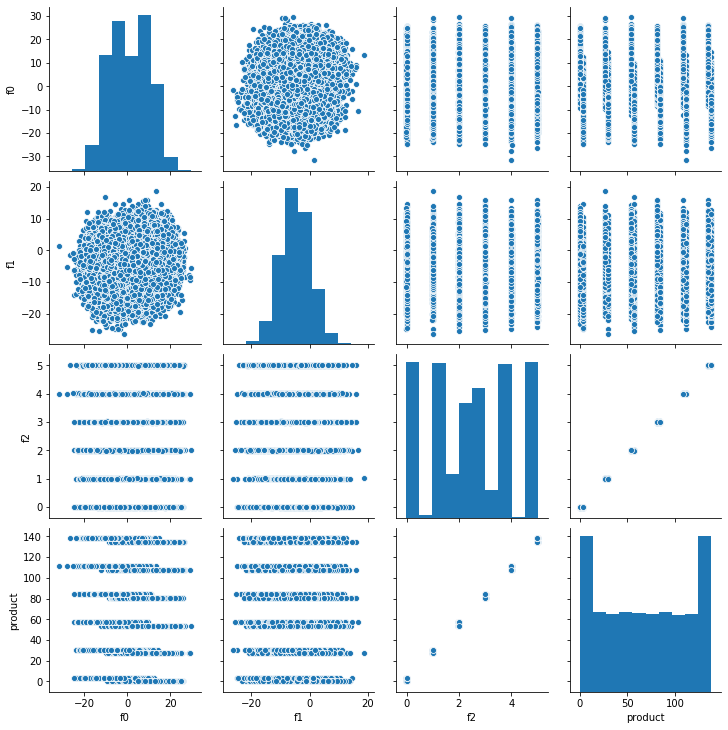


                                               region 3


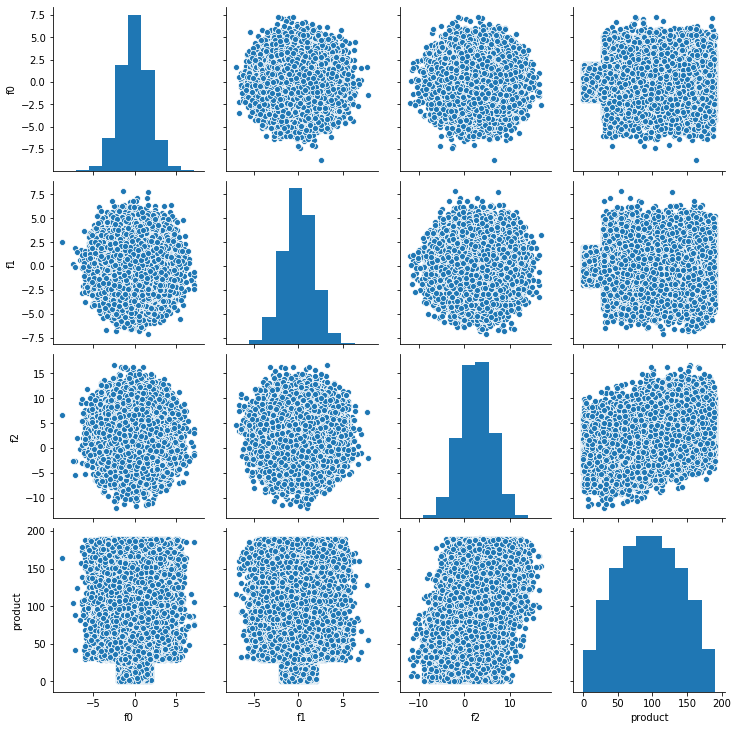

In [12]:
j = 1
for i in region_1, region_2, region_3:
    print('                                               region ' + str(j))
    sns.pairplot(i)
    plt.show()
    j += 1
    print()

Из графиков видно, что во втором регионе наблюдается взаимосвязь между признаками product и f2. Посмотрим на корреляцию между признаками , более 0.4 и менее -0.4:

- Регион 1

In [13]:
for i in region_1.drop(['id'], axis=1):
    for j in region_1.drop(['id'], axis=1):
        #print(i + ' : ' + j)
        #print(region_1[i].corr(region_1[j]))
        if i != j and 0.4 < region_1[i].corr(region_1[j]) or region_1[i].corr(region_1[j]) < -0.4:
            print(f'{i} : {j} корреляция = {region_1[i].corr(region_1[j])}')
            print()

f0 : f1 корреляция = -0.4407166957803474

f1 : f0 корреляция = -0.44071669578034744

f2 : product корреляция = 0.4836309827610896

product : f2 корреляция = 0.4836309827610898



- Регион 2

In [14]:
for i in region_2.drop(['id'], axis=1):
    for j in region_2.drop(['id'], axis=1):
        #print(i + ' : ' + j)
        #print(region_1[i].corr(region_1[j]))
        if i != j and 0.4 < region_2[i].corr(region_2[j]) or region_2[i].corr(region_2[j]) < -0.4:
            print(f'{i} : {j} корреляция = {region_2[i].corr(region_2[j])}')
            print()

f2 : product корреляция = 0.9993969736591177

product : f2 корреляция = 0.9993969736591176



- Регион 3

In [15]:
for i in region_3.drop(['id'], axis=1):
    for j in region_3.drop(['id'], axis=1):
        #print(i + ' : ' + j)
        #print(region_1[i].corr(region_1[j]))
        if i != j and 0.4 < region_3[i].corr(region_3[j]) or region_3[i].corr(region_3[j]) < -0.4:
            print(f'{i} : {j} корреляция = {region_3[i].corr(region_3[j])}')
            print()

f2 : product корреляция = 0.4458669943489574

product : f2 корреляция = 0.4458669943489574



Корреляция во втором регионе product и f2 почти 1. Очень странно.

# 2. Обучение и проверка модели

Разобъём данные на признаки и обучающий признак:

In [16]:
features_reg_ = ['', '', '', '']
target_reg_ = ['', '', '', '']
j = 1
for i in region_1, region_2, region_3:
    features_reg_[j] = i.drop(['product', 'id'], axis=1)
    target_reg_[j] = i['product']
    j += 1

Разобъём данные на обучающую и валидационную выборки:

In [17]:
features_train_reg_ = ['', '', '', '']
features_valid_reg_ = ['', '', '', '']
target_train_reg_ = ['', '', '', '']
target_valid_reg_ = ['', '', '', '']
for i in range(1, 4):
    features_train_reg_[i], features_valid_reg_[i], target_train_reg_[i], target_valid_reg_[i] = tts(features_reg_[i], target_reg_[i],
                                                                                                     test_size=0.25, random_state=12345)

Обучим модели и сделаем предсказания:

In [18]:
model_reg_ = ['', '', '', '']
predictions_reg_ = ['', '', '', '']
for i in range(1, 4):
    model_reg_[i] = lr()
    model_reg_[i].fit(features_train_reg_[i], target_train_reg_[i])
    predictions_reg_[i] = model_reg_[i].predict(features_valid_reg_[i])

Посмотрим на метрику R2 моделей:

In [19]:
for i in range(1, 4):
    print(f'R2 для для региона {i}: {model_reg_[i].score(features_valid_reg_[i], target_valid_reg_[i])}')

R2 для для региона 1: 0.2723923460817068
R2 для для региона 2: 0.9996222988190184
R2 для для региона 3: 0.19556241810202346


Метрика R2 очень низкая у 1-ой и третей модели, а у второй - почти эталонная.  

Посмотрим на метрику RMSE моделей:

In [20]:
rmse_reg_ = ['', '', '', '']
for i in range(1, 4):
    rmse_reg_[i] = mse(target_valid_reg_[i], predictions_reg_[i]) ** 0.5
    print(f'RMSE для для региона {i}: {rmse_reg_[i]}')

RMSE для для региона 1: 37.853527328872964
RMSE для для региона 2: 0.8920592647717003
RMSE для для региона 3: 40.07585073246016


Аналогично R2, RMSE показывает у первого и третего региона большие отклонения, а у второго немного меньше единицы.  

Посмотрим на средные абсолютния отклонение моделей:

In [21]:
for i in range(1, 4):
    print(f'MAE для для региона {i}: {mae(target_valid_reg_[i], predictions_reg_[i])}')

MAE для для региона 1: 31.141028675220262
MAE для для региона 2: 0.7193530096516079
MAE для для региона 3: 32.83139014902301


Картина примерно повторяет RMSE.

Посчитаем средний запас предсказанного сырья регионов и распечатаем RMSE:

In [22]:
predictions_mean_reg_ = ['', '', '', '']
for i in range(1, 4):
    predictions_mean_reg_[i] = predictions_reg_[i].mean()
    profit_mean_reg = predictions_mean_reg_[i] * profit_per_1k_barrel
    print(f'Метрика RMSE региона {i}: {rmse_reg_[i]}')
    print(f'Средний запас предсказанного сырья региона {i}: {predictions_mean_reg_[i]}')
    print(f'Средний доход с вышки от предсказанного сырья региона {i}: {profit_mean_reg}р.')
    print()

Метрика RMSE региона 1: 37.853527328872964
Средний запас предсказанного сырья региона 1: 92.78915638280621
Средний доход с вышки от предсказанного сырья региона 1: 41755120.3722628р.

Метрика RMSE региона 2: 0.8920592647717003
Средний запас предсказанного сырья региона 2: 69.17831957030432
Средний доход с вышки от предсказанного сырья региона 2: 31130243.806636944р.

Метрика RMSE региона 3: 40.07585073246016
Средний запас предсказанного сырья региона 3: 94.86572480562035
Средний доход с вышки от предсказанного сырья региона 3: 42689576.162529156р.



Модель второго региона предсказала наиболее похожие результаты(скорее всего из-за корреляции product и f2). Имеем средний запас сырья предсказаний примерно 69 тысяч баррелей, в отличае от более слабых предсказаний остальных моделей. В них средний запас более 90 тысяч баррелей.

# 3. Подготовка к расчёту прибыли

In [23]:
required_well_vol = (district_budget / profit_per_1k_barrel) / 200

In [24]:
print(f'Необходимый объём для безубыточной разработки: {required_well_vol}')
print()
for i in range(1, 4):
    print(f'Средний запас сырья в регионе {i}: {target_reg_[i].mean()}')
    print(f'Средний запас предсказанного сырья в регионе {i}: {predictions_mean_reg_[i]}')
    print()

Необходимый объём для безубыточной разработки: 111.11111111111111

Средний запас сырья в регионе 1: 92.49968421774328
Средний запас предсказанного сырья в регионе 1: 92.78915638280621

Средний запас сырья в регионе 2: 68.82391591806625
Средний запас предсказанного сырья в регионе 2: 69.17831957030432

Средний запас сырья в регионе 3: 94.99834211933415
Средний запас предсказанного сырья в регионе 3: 94.86572480562035



Необходимый объём сырья для бызубыточной разработки превышает средние объёмы скважим во всех регионов и по предсказаниям, и по фактическим данным.

# 4. Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели:

Random State для не случайной случайности =):

In [25]:
state = np.random.RandomState(12345)

Напишем функцию для подсчёта прибыли из заданного количества лучшых вышек:

In [26]:
def revenue(target, predictions, count):
    predictions = predictions.sort_values(ascending=False)  # [:count]
    top_count_reg = target.loc[predictions.index][:count]  # отбор по таргету рекоммендуют
    product = top_count_reg.sum()    
    income = product * profit_per_1k_barrel
    profit = income - district_budget
    return profit

Возьмём из валидационных частей каждого региона по 500 случайных вышек:

In [27]:
count_random_target = 500
target_valid_500_reg_ = ['', '', '', '']
features_valid_500_reg_ = ['', '', '', '']
for i in range(1, 4):
    target_valid_500_reg_[i] = target_valid_reg_[i].sample(count_random_target, random_state=state)
    features_valid_500_reg_[i] = features_valid_reg_[i].loc[target_valid_500_reg_[i].index]

Сделаем предсказания для каждого регионга и применим к ним функцию revenue с 200 вышками:

In [28]:
count_top = 200
for i in range(1, 4):
    predictions_500_reg = model_reg_[i].predict(features_valid_500_reg_[i])
    predictions_500_series_reg = pd.Series(predictions_500_reg, index=target_valid_500_reg_[i].index)
    print(f'Средняя прибыль лучших {count_top} вышек региона {i}: {revenue(target_valid_500_reg_[i], predictions_500_series_reg, count_top)}р.')

Средняя прибыль лучших 200 вышек региона 1: 146566189.6093464р.
Средняя прибыль лучших 200 вышек региона 2: 481293884.0571213р.
Средняя прибыль лучших 200 вышек региона 3: 192788807.9456234р.


По расчётам, прибыль положительна, что значит работа не в минус по всем трём рпегионам. Но во втором регионе прибыль больше чем в 2 раза превышает прибыли в первом и третьем.

# 5. Расчёт прибыли и рисков 

In [29]:
count_bootstraps = 1000
values_ = ['', [], [], []]
for j in range(1, 4):
    for i in range(count_bootstraps):
        target_subsample_reg = target_valid_reg_[j].sample(n=count_random_target, replace=True, random_state=state)
        predictions_prob_reg = pd.Series(predictions_reg_[j], target_valid_reg_[j].index)
        probs_subsample_reg = predictions_prob_reg.loc[target_subsample_reg.index]
        rev = revenue(target_subsample_reg, probs_subsample_reg, 200)
        values_[j].append(rev)

In [30]:
for i in range(1, 4):
    values_[i] = pd.Series(values_[i])
    mean_profit = values_[i].mean()
    risk = (values_[i] < 0).mean()
    confidence_interval = (values_[i].quantile(0.025), values_[i].quantile(0.975))
    print(f'Средняя прибыль для региона {i}: {mean_profit}')
    print(f'95%-й доверительный интервал для региона {i}: {confidence_interval}')
    print(f'Риск убытков региона {i}: {risk * 100}%')
    print()

Средняя прибыль для региона 1: 404768671.647677
95%-й доверительный интервал для региона 1: (-124579318.31880021, 919044884.7551963)
Риск убытков региона 1: 6.800000000000001%

Средняя прибыль для региона 2: 538017643.8963279
95%-й доверительный интервал для региона 2: (115219876.04617979, 994975871.1114624)
Риск убытков региона 2: 0.6%

Средняя прибыль для региона 3: 351417832.0238033
95%-й доверительный интервал для региона 3: (-203286464.35090545, 870608678.4983889)
Риск убытков региона 3: 10.0%



Судя по показателям, больше всего подходит регион 2.

# 6. Общий вывод:

Были проверены и обработаны данные для исследований. Выявился подазрительный момент с корреляцией во втором регионе между признаком f2 и целевым признаком product. Исследованы и проверены модели. Проведены расчёты прибыли по случайно выбранным предсказаниям моделей, из которых были отобраны лучшие 200. Оценены риски и срнедняя прибыль по общей валидационной выборке всех регионов. Есть основания предложить для разработки регион 2. Риски там минимальны, особенно на фоне остальных регионов. Прибыль по доверительному интервалу выше, чем в остальных регионах.